# Hands on Session 2: Chemical Descriptors

This tutorial is a basic introduction into machine learning (ML) workflows in the context of molecular simulation and computational materials research. The notebook introduces workflows and concepts related to

    * Data preparation and analysis
    * Generating chemical representations and features
    * Dimensionality Reduction
    * Clustering

The notebook is adapted from an original by Reinhard Maurer: https://workshop.camml.ac.uk/notebooks/01-intro/tutorial.html

## Setup

We first need to obtain the data and set up our working environment. The code here will do that for you.

In [1]:
# only if you run in google colab

import locale
locale.getpreferredencoding = lambda: "UTF-8"

! pip install scikit-learn dscribe opentsne data-tutorials weas-widget
get_ipython().kernel.do_shutdown(restart=True)

!unzip cyclohexane_data.zip -d cyclohexane_data

!pip -q install "ase<3.23"
!pip -q install py3Dmol

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.4 MB/s eta 0:00:00


## Do the imports

Import the various tools we will need.

In [2]:
#basic stuff
import os
import sys
from functools import partial
import numpy as np
import ase
import random
from ase.io import read, write
from ase.visualize import view
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas
import seaborn as sns
from ase.build import molecule
from weas_widget import WeasWidget

#ML stuff
import dscribe
import sklearn
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm # progress bars for loops

%matplotlib inline

# Visualise
import py3Dmol
from ase.io import write

## Read in the data for analysis

Let’s start with a dataset of five short MD simulations of different conformers of cyclohexane.

We start five independent simulations initialized within each of the known cyclohexane conformers shown in the below figure. The MD simulations were run for 10,000 time steps each. The data contains the atom positions, velocities, energies and forces. These types of MD simulations will explore the energy landscape and settle within local and/or global minima.

In [3]:
# read in the frames from each MD simulation
traj = []
names = ['chair', 'twist-boat', 'boat', 'half-chair', 'planar']
rgb_colors = [(0.13333333333333333, 0.47058823529411764, 0.7098039215686275),
                (0.4588235294117647, 0.7568627450980392, 0.34901960784313724),
                (0.803921568627451, 0.6078431372549019, 0.16862745098039217),
                (0.803921568627451, 0.13725490196078433, 0.15294117647058825),
                (0.4392156862745098, 0.2784313725490196, 0.611764705882353),]

ranges = np.zeros((len(names), 2), dtype=int)
conf_idx = np.zeros(len(names), dtype=int)

for i, n in enumerate(names):
    print('Reading in ', n)
    frames = read(f'./cyclohexane_data/cyclohexane_data/MD/{n}.xyz', '::')

    for frame in frames:
        # wrap each frame in its box
        frame.wrap(eps=1E-10)

        # mask each frame so that descriptors are only centered on carbon (#6) atoms
        mask = np.zeros(len(frame))
        mask[np.where(frame.numbers == 6)[0]] = 1
        frame.arrays['center_atoms_mask'] = mask

    ranges[i] = (len(traj), len(traj) + len(frames)) #list of data ranges
    conf_idx[i] = len(traj) # handy list to indicate the index of the first frame for each trajectory
    traj = [*traj, *frames] # full list of frames, 50000 entries

Reading in  planar


## Visualise the data

As always we start by looking at the data and see if it makes sense.

**Task for you**
<div class="alert alert-block alert-info">
    Visualise all of the tranjectories. Do you think that any of them seem to have bigger changes in configuration than others? Do all of the configurations stay intact or do any of them convert into antoher configuration?
</div>




In [4]:
#pick a molecule to visualize its trajectory
# ['chair', 'twist-boat', 'boat', 'half-chair', 'planar']
molecule = 'planar'
########
i = names.index(molecule)
r = ranges[i]
mol_traj = traj[r[0]:r[1]]
mol_traj_small = mol_traj[::50]

print("Visualizing '{0}' trajectory".format(molecule))
write("traj.xyz", mol_traj_small)

xyz = open("traj.xyz").read()

view = py3Dmol.view(width=600, height=400)
view.addModelsAsFrames(xyz, "xyz")
view.setStyle({"stick": {}, "sphere": {"scale": 0.3}})
view.animate({"loop": "forward", "interval": 100})
view.zoomTo()
view.show()

Visualizing 'planar' trajectory


/usr/local/lib/python3.12/dist-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Look at the energies

The code below will allow you to plot the internal energy of the system along  the trajectory for each of the configurations. Look at the energies, do the trends conform to what you saw in the MD visulaistion?

In [5]:
# energies of the simulation frames
energy = np.array([a.info['energy_eV'] for a in traj])

# energies of the known conformers
c_energy = np.array([traj[c].info['energy_eV'] for c in conf_idx])

# extrema for the energies
max_e = max(energy)
min_e = min(energy)

print('energy range goes from {0:10.6f} to {1:10.6f} eV'.format(min_e, max_e))

energy range goes from -1124.005306 to -1122.630357 eV


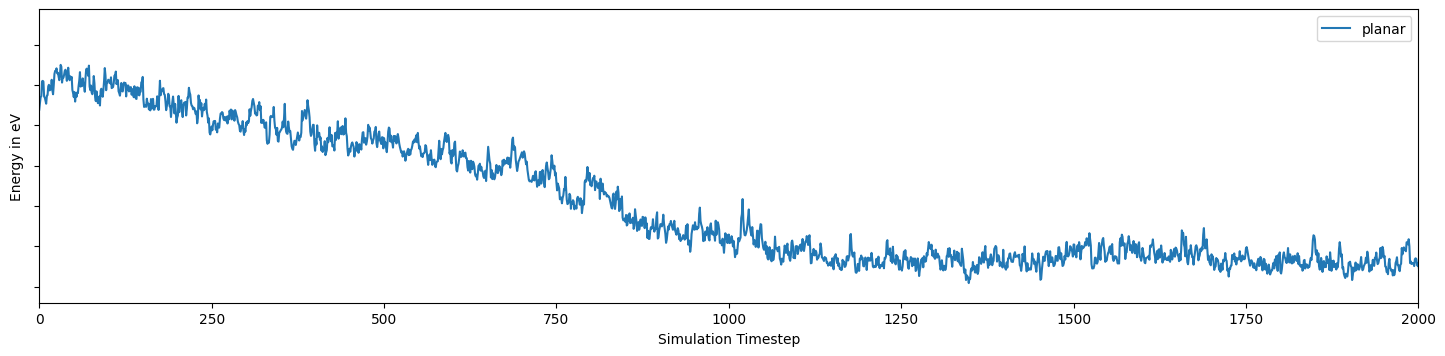

In [6]:
fig, ax = plt.subplots(1, figsize=(3*4.8528, 3*1.2219))

for n, c, r, rgb in zip(names, c_energy, ranges, rgb_colors):
    ax.plot(range(0, r[1] - r[0]),
            energy[r[0]:r[1]] - min_e,
            label=n,
            c=rgb,
            zorder=-1)

ax.legend()
ax.set_xlabel("Simulation Timestep")
ax.set_ylabel("Energy in eV")

ax.set_xlim([0, len(energy)//5])
ax.set_ylim([-0.1, 1.25 * (max_e - min_e)])
ax.set_yticklabels([])

plt.tight_layout()
plt.savefig('energy.png')
plt.show()

## Descriptors

We will now play around with two different examples of descriptors to capture the key features of the dynamics. First, we will look at a global descriptor and then at an atom-centered descriptor.

This will include
- Coulomb Matrix (global)
- Many body tensor representatiton (global)
- SOAP (atom-centered)

### Coulomb Matrix

Coulomb Matrix (CM) is a simple global descriptor which mimics the
electrostatic interaction between nuclei.

Coulomb matrix is calculated with the equation below.

$$
    \begin{equation}
    M_{ij}^\mathrm{Coulomb}=\left\{
        \begin{matrix}
        0.5 Z_i^{2.4} & \text{for } i = j \\
            \frac{Z_i Z_j}{R_{ij}} & \text{for } i \neq j
        \end{matrix}
        \right.
    \end{equation}
$$

The diagonal elements can be seen as the interaction of an atom with itself. The strange exponent arises from an attempt to correlate the trend of the atomic energy w.r.t $Z_i$. If the diagonal elements can closely capture that trend, it goes along way in correctly capturing molecular stability. The off-diagonal elements represent the Coulomb repulsion between nuclei $i$ and $j$. Therefore, all elements of the representation are physically motivated.

In [8]:
import collections.abc
collections.Iterable = collections.abc.Iterable # this is unfortunately necessary for compatbility of describe with Py>=3.10
from dscribe.descriptors import CoulombMatrix

atomic_numbers = [1, 6] # H and C atoms

# Setting up the CM descriptor
cm = CoulombMatrix(
    n_atoms_max=18, # maximum no. atoms in the studied molecules
    #permutation = 'eigenspectrum',
    #permutation="sorted_l2"
)

In [9]:
# Create CM output for the system
coulomb_matrices =cm.create(traj)
print("flattened", coulomb_matrices.shape)
print('50000 MD frames, each has a descriptor of length 324 (18x18 matrix flattened)')

flattened (20000, 324)
50000 MD frames, each has a descriptor of length 324 (18x18 matrix flattened)


In [ ]:
print(coulomb_matrices[0])

[36.8581052  23.52976768 23.52996745 14.40897513 12.28815501 14.4090546
  2.78527396  2.2011201   2.20114941  2.78521177  5.50461244  1.81880242
  2.78524139  5.50453046  1.74096637  2.78519691  1.5324255   1.7409567
 23.52976768 36.8581052  14.40903531 12.28789784 14.40898656 23.52965341
  5.50493067  2.78515777  1.81877514  2.2011196   2.78514297  2.20119847
  1.74097033  2.78517683  2.7852014   5.50449618  1.74095823  1.53241021
 23.52996745 14.40903531 36.8581052  23.52906909 14.40905633 12.28781458
  2.20115081  1.81874643  2.78515369  5.50477411  2.78519189  2.20115
  5.50458288  2.78524289  1.53241209  1.74096061  1.74094962  2.78515671
 14.40897513 12.28789784 23.52906909 36.8581052  23.52985476 14.40858416
  1.81873782  2.20112271  5.50477405  2.7851537   2.20110154  2.78514788
  2.78518582  1.74095729  1.74093733  1.53241105  2.7851844   5.50448596
 12.28815501 14.40898656 14.40905633 23.52985476 36.8581052  23.5284206
  2.20109789  2.78521176  2.78528553  2.20112011  1.81874

**Task for you**
<div class="alert alert-block alert-info">
    
- Take a look at one of the CM descriptors for a given frame. Compare to the list of atoms. Does it make sense?
- Why does the descriptor have the length that it has?
    
</div>

## Checking for invariance

A good descriptor should be invariant with respect to atom permutations, translations, and rigid rotations. However, for the CM, it matters in which order the atoms appear. Changing of atom ordering leads to swapping of rows and columns in the matrix. This should raise alarm bells as it means that it isn't invariant to atom index permutations and therefore not suitable for general machine learning.

**Task for you**
<div class="alert alert-block alert-info">
    
- The CM construction above allows for multiple different options for `permutation`. Read the [DScribe documentation](https://singroup.github.io/dscribe/0.3.x/tutorials/coulomb_matrix.html) and try different ones. Which one satisfies permutational invariance? This is the one we should be using.
</div>

In [13]:
def matprint(mat, fmt="g", size=18):
    if len(mat.shape)>1:
        #mat = mat.reshape([size,size])
        col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
        for x in mat:
            for i, y in enumerate(x):
                print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
            print("")
    else:
        words = ["{0:8.4f}".format(x) for x in mat]
        print(" ".join(words))

# Setting up the CM descriptor
cm = CoulombMatrix(
    n_atoms_max=18, # maximum no. atoms in the studied molecules
    permutation = 'eigenspectrum',
    #permutation="sorted_l2"
)

#Pick first molecule frame
first_frame = frames[0]
cm_original = cm.create(first_frame)
print('Original CM')
#print(cm_original)
matprint(cm_original)

# Translation
first_frame.translate((5, 7, 9))
cm_translated = cm.create(first_frame)
print('Translated CM')
matprint(cm_translated)

# Rotation
first_frame.rotate(90, 'z', center=(0, 0, 0))
cm_rotated = cm.create(first_frame)
print("Rotated CM")
matprint(cm_rotated)

# Permutation
upside_down = first_frame[::-1]
cm_upside_down = cm.create(upside_down)
print("upside down CM")
matprint(cm_upside_down)

print('Differences due to translation')
trans_diff = (cm_translated-cm_original)
matprint(trans_diff)
print('Differences due to rotation')
rot_diff = (cm_rotated-cm_original)
matprint(rot_diff)
print('Differences due to permutation')
permut_diff = (cm_upside_down-cm_original)
matprint(permut_diff)

Original CM
128.0230  36.3519  36.3515  12.1812  12.1812   5.9500  -1.0803  -0.7547  -0.7547  -0.3983  -0.3983  -0.2372   0.2045  -0.1763  -0.1763  -0.1072  -0.0057  -0.0057
Translated CM
128.0230  36.3519  36.3515  12.1812  12.1812   5.9500  -1.0803  -0.7547  -0.7547  -0.3983  -0.3983  -0.2372   0.2045  -0.1763  -0.1763  -0.1072  -0.0057  -0.0057
Rotated CM
128.0230  36.3519  36.3515  12.1812  12.1812   5.9500  -1.0803  -0.7547  -0.7547  -0.3983  -0.3983  -0.2372   0.2045  -0.1763  -0.1763  -0.1072  -0.0057  -0.0057
upside down CM
128.0230  36.3519  36.3515  12.1812  12.1812   5.9500  -1.0803  -0.7547  -0.7547  -0.3983  -0.3983  -0.2372   0.2045  -0.1763  -0.1763  -0.1072  -0.0057  -0.0057
Differences due to translation
  0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000  -0.0000   0.0000   0.0000   0.0000   0.0000
Differences due to rotation
 -0.0000   0.0000   0.0000   0.0000   0.0000   0.0000  -0.0000  -0.0000  -0.000

## Look at the distribution of values

Look at the distribution of values of the coulomb matrices, does it make sense?


**Task for you**
<div class="alert alert-block alert-info">
    
- Can you try to ascribe an environment/pair type to each of the modes in the distribution?
</div>

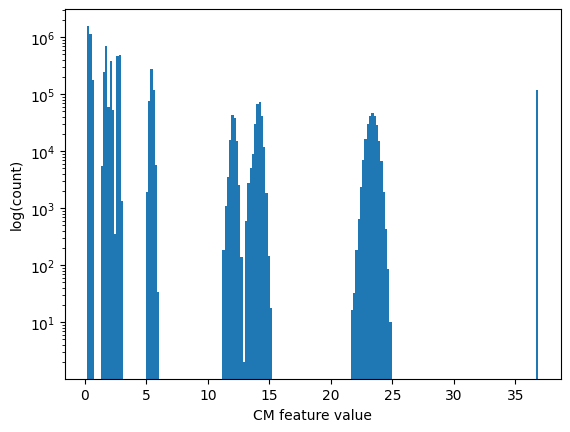

In [14]:
counts, bins = np.histogram(coulomb_matrices.flatten(),bins=200)
#plt.stairs(counts, bins)
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('CM feature value')
plt.ylabel('log(count)')
plt.yscale('log')
plt.show()

## Many-body Tensor Representation

The many-body tensor representation (MBTR) encodes a structure by using a distribution of different structural motifs. It can be used directly for both finite and periodic systems. MBTR is especially suitable for applications where interpretability of the input is important because the features can be easily visualized and they correspond to specific structural properties of the system (distances, angles, dihedrals).

The MBTR representation can be used as a global representation (one feature vector per system) or as an atom-centered or local one (one feature vector per atom). As a global descriptor, the individual contributions are discretised on a single spectrum for the molecule as shown in the below figure.

![bla](https://singroup.github.io/dscribe/latest/_images/mbtr.jpg)

In [7]:
import collections.abc
collections.Iterable = collections.abc.Iterable # this is unfortunately necessary for compatbility of describe with Py>=3.10
from dscribe.descriptors import MBTR

min_dist = 0.8  #smallest distance in Angstrom
max_dist = 12.0  #largest distance in Angstrom
#we are constructing MBTR with inverse distances
grid_min = 1.0/max_dist # 1/Angstrom
grid_max = 1.0/min_dist # 1/Angstrom
grid_n = 100 # number of grid points
sigma = 0.05

#k=1, 1-body
#"atomic_number": The atomic number.
#k=2, 2-body
#"distance": Pairwise distance in angstroms.
#"inverse_distance": Pairwise inverse distance in 1/angstrom.
#k=3, 3-body
#"angle": Angle in degrees.
#"cosine": Cosine of the angle.

# MBTR setup for cyclohexane dataset
mbtr = MBTR(
    species=["H", "C"],
    geometry={"function": "inverse_distance"}, # only 2-body terms, no 3-body
    grid={"min": grid_min, "max": grid_max, "n": grid_n, "sigma": sigma},
    weighting={"function": "exp", "scale": 0.5, "threshold": 1e-3},
    periodic=False,
    normalization="l2",
    sparse=False
)

In [9]:
mbtrs = mbtr.create(traj)
#mbtrs = mbtr.create(traj[:10])
print(mbtrs.shape)

(10000, 300)


## Visualise the MBTR

We can look at the MBTR for a given frame - we can also decompose it by pair type.

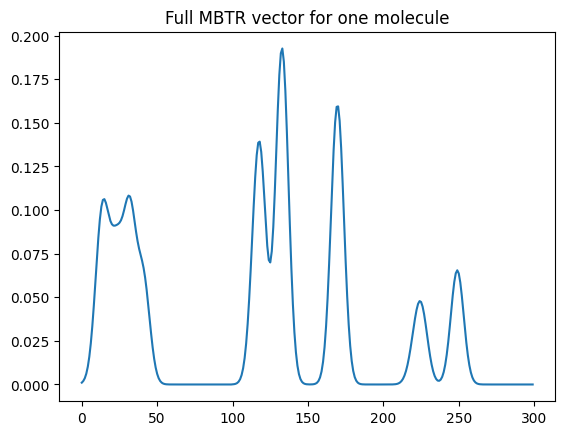

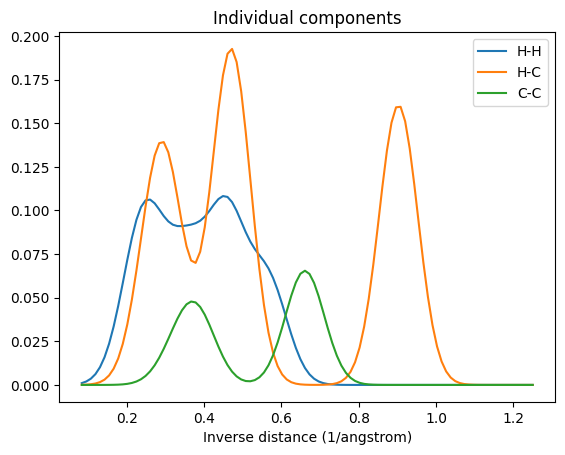

In [10]:
plt.plot(mbtrs[0])
plt.title('Full MBTR vector for one molecule')


# Create the mapping between an index in the output and the corresponding
# chemical symbol
n_elements = len(mbtr.species)
x = np.linspace(grid_min, grid_max, grid_n)

# Plot k=2
if mbtr.k==2:
    fig, ax = plt.subplots()
    for i in range(n_elements):
        for j in range(n_elements):
            if j >= i:
                i_species = mbtr.species[i]
                j_species = mbtr.species[j]
                loc = mbtr.get_location((i_species, j_species))
                plt.plot(x, mbtrs[0][loc], label="{}-{}".format(i_species, j_species))
    if mbtr.geometry['function'] == 'inverse_distance':
        ax.set_xlabel("Inverse distance (1/angstrom)")
    else:
        ax.set_xlabel("distance (angstrom)")
    plt.title('Individual components')

#plot k=3
if mbtr.k==3:
    fig, ax = plt.subplots()
    for i in range(n_elements):
        for j in range(n_elements):
            for k in range(n_elements):
                        i_species = mbtr.species[i]
                        j_species = mbtr.species[j]
                        k_species = mbtr.species[k]
                        loc = mbtr.get_location((i_species, j_species, k_species))
                        plt.plot(x, mbtrs[0][loc], label="{}-{}-{}".format(i_species, j_species, k_species))
    if mbtr.geometry['function'] == 'angle':
        ax.set_xlabel("angle in rad")
    else:
        ax.set_xlabel("cos(angle)")

    plt.title('Individual components')


ax.legend()
plt.show()

**Task for you**
<div class="alert alert-block alert-info">
    
Does the MBTR obey the invariances you tested previously for the CM?
</div>

In [ ]:
## Space to play around

## Smooth Overlap of Atomic Postitions (SOAP)

Smooth Overlap of Atomic Positions (SOAP) is a descriptor that encodes regions of atomic geometries by using a local expansion of a gaussian smeared atomic density with orthonormal functions based on spherical harmonics and radial basis functions.

$$
   p^{Z_1 Z_2}_{n n' l} = \pi \sqrt{\frac{8}{2l+1}}\sum_m {c^{Z_1}_{n l m}}^*c^{Z_2}_{n' l m}
$$

here $n$ and $n'$ are indices for the different radial basis
functions up to $n_\mathrm{max}$, $l$ is the angular degree of the
spherical harmonics up to $l_\mathrm{max}$ and $Z_1$ and $Z_2$
are atomic species.

The coefficients $c^Z_{nlm}$ are defined as the following inner
products:

$$
   c^Z_{nlm} =\iiint_{\mathcal{R}^3}\mathrm{d}V g_{n}(r)Y_{lm}(\theta, \phi)\rho^Z(\mathbf{r}).
$$

where $\rho^Z(\mathbf{r})$ is the gaussian smoothed atomic density for
atoms with atomic number $Z$ defined as

$$
   \rho^Z(\mathbf{r}) = \sum_i^{\lvert Z_i \rvert} e^{-1/2\sigma^2 \lvert \mathbf{r} - \mathbf{R}_i \rvert^2}
$$

$Y_{lm}(\theta, \phi)$ are the real spherical harmonics, and
$g_{n}(r)$ is the radial basis function.

For the radial degree of freedom, $g_{n}(r)$, multiple approaches may be used. By
default the DScribe implementation uses spherical gaussian type orbitals as
radial basis functions, as they allow  faster analytic computation.

The SOAP similarity kernel between two atomic environments can be retrieved
as a normalized polynomial kernel of the partial powers spectrums:
$$
   K^\mathrm{SOAP}(\mathbf{p}, \mathbf{p'}) = \left( \frac{\mathbf{p} \cdot \mathbf{p'}}{\sqrt{\mathbf{p} \cdot \mathbf{p}~\mathbf{p'} \cdot \mathbf{p'}}}\right)^{\xi}
$$

Starting point for parameters:
- `r_cut=3.5`: we are considering 3.5A radius of sphere for describing each atom environments. For cyclohexane, this includes the whole ring, which is necessary to differentiate conformers
- `n_max=4`: expand over 4 radial GTO bases
- `l_max=4`: expand over the first 4 spherical harmonics
- `sigma=0.3`: assume each atom has a gaussian of size sigma=0.3 imposed on its lattice site

SOAP is a descriptor centred around atoms. For the construction of machine learning interatomic potentials, this is beneficial.

## Set up some SOAPS

More details are available on [the Dscribe webpage](https://singroup.github.io/dscribe/0.3.x/tutorials/soap.html).

In [11]:
from dscribe.descriptors import SOAP

species = ["H", "C"]
r_cut = 3.5 #cutoff in Angstrom
n_max = 4 #
sigma = 0.3 #stdev of gaussians
l_max = 4

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
    sigma=sigma,
)

# Create SOAP output for all frames
soaps = soap.create(traj)
print(soaps.shape)

(10000, 18, 180)


We get a descriptor array with 3 dimensions: no. of frames, no. of atoms, and length of SOAP feature vector.

**Task for you**

<div class="alert alert-block alert-info">
Show that the SOAP descriptors are also invariant w.r.t. to translations, permutations, and rotations
</div>

## Making SOAP Global

Measuring the similarity of structures becomes easy when the feature vectors represent the whole structure, such as in the case of Coulomb matrix or MBTR. In these cases the similarity between two structures is directly comparable  with different kernels, e.g. the linear or Gaussian kernel.

Sometimes, we are focussed on comparative analysis between systems, then it is more useful to have a global descriptor. We can transform SOAPs (and other atom-centered descriptors) into a global descriptor. We can achieve this by generating an average kernel. DScribe enables this with the option `average='inner'`.


In [12]:
# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
    sigma=sigma,
    average='inner',
)
# Create SOAP output for all frames
soaps = soap.create(traj)
print(soaps.shape)


(10000, 180)


In [13]:
#Let's generate two different soap descriptors with different settings so we hvae them handy
from dscribe.descriptors import SOAP

species = ["H", "C"]
r_cut = 3.5 #cutoff in Angstrom
n_max = 4 #
sigma = 0.3 #stdev of gaussians
l_max = 4

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
    sigma=sigma,
    average='inner',
)

soaps_default = soap.create(traj)

species = ["H", "C"]
r_cut = 3.5 #cutoff in Angstrom
n_max = 6 #
sigma = 0.3 #stdev of gaussians
l_max = 6

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
    sigma=sigma,
    average='inner',
)

soaps_high = soap.create(traj)

## Similarity analysis

We can use our new descriptors to find the configurational change of the planar configuration without knowing anything about the structure. In the following box, we use a pairwise kernel from scikit-learn to compare structures for their similarity. For each trajectory, we compare the last frame with all other frames.

In [17]:
descriptors = soaps_default
#descriptors = soaps_high
#descriptors = coulomb_matrices
#descriptors = mbtrs

similarities = np.zeros((len(traj), 5))
kernel = partial(pairwise_kernels, metric='rbf', gamma=2.0) #allows us to call pairwise_kernel like a function later

ranges2 = ranges.copy()
ranges2[4,1] = -1
for i, ci in enumerate(tqdm(conf_idx)):
    ki = kernel(descriptors[ranges2[i,0]].reshape(1,-1), descriptors)
    similarities[:, i] = ki

  0%|          | 0/1 [00:00<?, ?it/s]

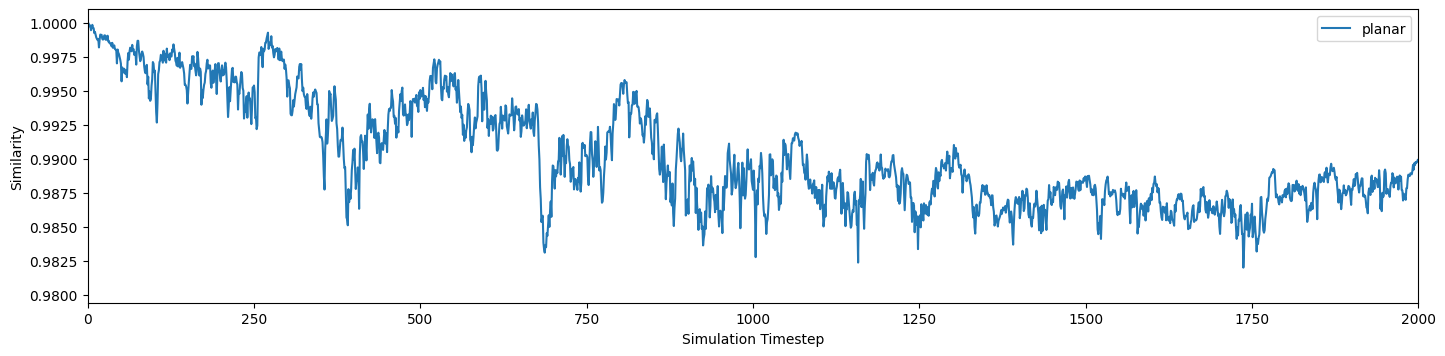

In [18]:
fig, ax = plt.subplots(1, figsize=(3*4.8528, 3*1.2219))

for i, (n, c, r, rgb) in enumerate(zip(names, c_energy, ranges, rgb_colors)):
    ax.plot(range(0, r[1] - r[0]),
            similarities[r[0]:r[1],i],
            label=n,
            c=rgb,
            zorder=-1)

ax.legend()
ax.set_xlabel("Simulation Timestep")
ax.set_ylabel("Similarity")

ax.set_xlim([0, len(energy)//5])
#ax.set_ylim([-0.1, 1.25 * (max_e - min_e)])
#ax.set_yticklabels([])

plt.tight_layout()

plt.show()

Using the SOAP descriptors, we see that all configurations retain similarity with the initial structure except for the planar structure, which starts in a structure that is disimilar to the final frame.

**Task for you**
<div class="alert alert-block alert-info">
    
- Go back up and retry this with the CM and MBTR descriptors. Then try tuning the SOAP with higher n_max and l_max. Can you improve the similarity description? Which descriptor performs best? The similarity difference between the initial and final structure of the planar geometry is a good indicator of the "resolving power" of the descriptor.
</div>


In [ ]:
## Space to play

## Dimensionality reduction

Let's look at dimensionality reduction and clustering techniques. Can we come up with representations that clearly resolve the structural differences in the data?

## Principal component analysis (PCA)

PCA is the simplest linear dimensionality reduction technique based on Singular value Decomposition. The idea is to find a small set of principal components that represent the maximum amount of variance (diversity) in the data. We then project the data into that lower dimensional space. There are many variations on this technique including non-linear ones (Kernel PCA).

[0.37714401 0.29458839 0.13876305 0.08180168 0.0466251 ]
[7.29862587 6.45052857 4.42715174 3.39913644 2.56624066]
Total variance of 5 lowest eigenvalues: 0.9389222276624491
Total variance of 2 lowest eigenvalues 0.6717324016449779


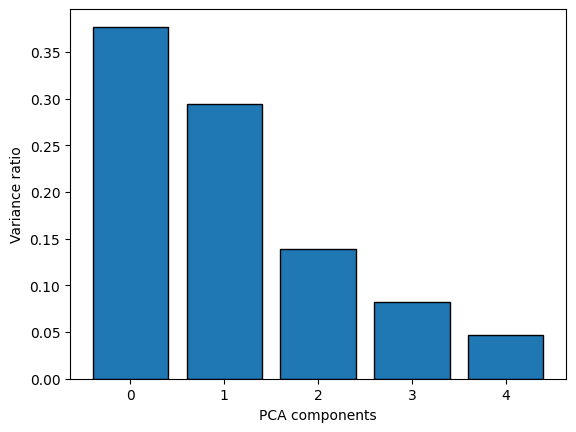

In [ ]:
from sklearn.decomposition import PCA

#pick either
#descriptors = soaps_default
#descriptors = soaps_high
#descriptors = soaps_big
#descriptors = coulomb_matrices
descriptors = mbtrs

n_components = 5

pca = PCA(n_components=n_components) #looking at the 5 largest eigenvalues
pca.fit(descriptors)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
# this is the part where we transform the data into the PCA representation. Now each element of the descriptor corresponds to the respective PCA eigenvalue
X_new = pca.transform(descriptors)

plt.xlabel("PCA components")
plt.ylabel("Variance ratio")

plt.bar(np.arange(5),pca.explained_variance_ratio_, edgecolor='black')

print('Total variance of {0} lowest eigenvalues: {1}'.format(n_components, np.sum(pca.explained_variance_ratio_)))
print('Total variance of 2 lowest eigenvalues {0}'.format(np.sum(pca.explained_variance_ratio_[:2])))

The above plot shows us the variance captured by the 5 largest eigenvalues. Together the 5 components dominantly represent the data. The 2 lowest components cover a significant part of the variance.

**Task for you**
<div class="alert alert-block alert-info">
    
Can you find the descriptor that captures the most vaiance in the top two features? You can also tune that descriptor to maximise the number.
</div>

We pick the two components with the highest variance over the data and plot them against each other

In [ ]:
print(X_new.shape)
descriptors = X_new[:,:2]
print(descriptors.shape)

(50000, 5)
(50000, 2)


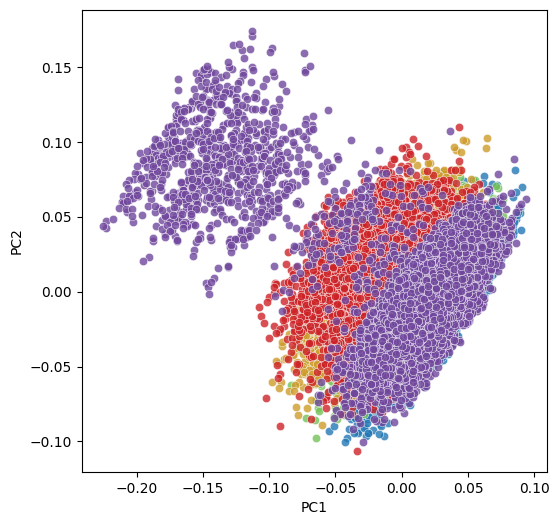

In [ ]:
fig, ax = plt.subplots(1, 1)

for (r, rgb) in zip(ranges,rgb_colors):
    ax.scatter(descriptors[r[0]:r[1],0], descriptors[r[0]:r[1],1], edgecolors='white', color=rgb, linewidths=0.4, label="datapoints", alpha=0.8)

plt.xlabel("PC1")
plt.ylabel("PC2")
fig.set_figheight(6.0)
fig.set_figwidth(6.0)

plt.show()

Let's only plot the 'planar' trajectory and colour the dots according to the trajectory time. Red are early times, blue are late times.

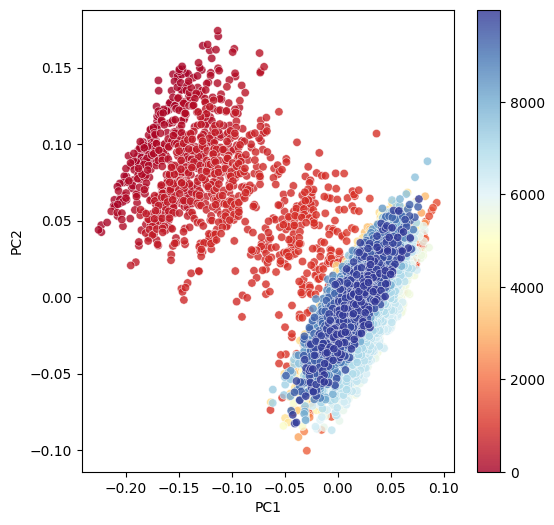

In [ ]:
fig, ax = plt.subplots(1, 1)

cm = plt.get_cmap('RdYlBu')
colors = range(10000)

sc = ax.scatter(descriptors[40000:,0], descriptors[40000:,1], edgecolors='white',
            c=colors, linewidths=0.4, label="datapoints", alpha=0.8, cmap=cm)
fig.colorbar(sc)


plt.xlabel("PC1")
plt.ylabel("PC2")
fig.set_figheight(6.0)
fig.set_figwidth(6.0)

plt.show()

We can see that the deformation of the molecule out of the planar geometry can be captured well with the two principal components. However, the subtle differences between structures are not well resolved. We will try another method below.

**Task for you**
<div class="alert alert-block alert-info">
    
- Compare the PCA plots for CM, MBTR, SOAP(n_max=4, l_max=4) (`soaps_default`), SOAP(n_max=6,l_max=6) (`soaps_high`).

</div>

## t-SNE

 t-Distributed Stochastic Neighbor Embedding (t-SNE) is a popular dimensionality-reduction algorithm for visualizing high-dimensional data sets. It can be very informative (and sometimes also a bit misleading). Both methods are nonlinear (in contrast to PCA). t-SNE focuses on preserving the pairwise similarities between data points in a lower-dimensional space. t-SNE is concerned with preserving small pairwise distances whereas, PCA focuses on maintaining large pairwise distances to maximize variance.

 So PCA preserves the variance in the data, whereas t-SNE preserves the relationships between data points in a lower-dimensional space, making it quite a good algorithm for visualizing complex high-dimensional data and relationships between individual datapoints.

 Popular libraries for t-SNE (or an alternative algorithm called UMAP) are
 - [openTSNE](https://opentsne.readthedocs.io/en/stable/)
 - [umap-learn](https://umap-learn.readthedocs.io/en/latest/)

In [ ]:
from openTSNE import TSNE

In [ ]:
#list of colors where each point is colored according to its trajectory

subsampling = 10 #consider only every 10th datapoint

data_length = 10000//subsampling

colors = []
for c in rgb_colors:
    for i in range(data_length):
        colors.append(c)

#list of colors for one trajectory which indicates time


##pick a descriptor
#descriptors = soaps_default[::subsampling,:]
#descriptors = soaps_high[::subsampling,:]
#descriptors = soaps_big[::subsampling,:]
#descriptors = coulomb_matrices[::subsampling,:]
descriptors = mbtrs[::subsampling,:]

The **perplexity** is an important tunable parameter for t-SNE.
Here we can see how increasing the perplexity (number of expected neighbors) changes the layout of the projection.

<div class="alert alert-block alert-danger">
    
This algorithm may take several minutes. Be sure to parallelize it (`n_jobs`) and be patient. Above, we have already sliced the datasets to only take every 10th datapoint (1000 data points for each trajectory).
</div>

In [ ]:
perplexities = np.logspace(0, 2.69, 6, dtype=int)
fig, ax = plt.subplots(1,
                       len(perplexities),
                       figsize=(4 * len(perplexities), 4),
                      )

for i, perp in enumerate(tqdm(perplexities)):
    tsne = TSNE(
        n_components=2,  # number of components to project across
        perplexity= perp,
        metric="euclidean",  # distance metric
        n_jobs=6,  # parallelization
        random_state=42,
        verbose=False,
    )
    t_tsne = tsne.fit(descriptors)
    ax[i].scatter(*t_tsne.T, c=colors, s=2)
    ax[i].axis('off')
    ax[i].set_title("Perplexity = {}".format(perp))
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]